# Build a Multi-output Model

In this lab, I'll build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [4]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [5]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [6]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 962us/sample - loss: 228.1848 - y1_output_loss: 103.5788 - y2_output_loss: 122.5051 - y1_output_root_mean_squared_error: 10.2249 - y2_output_root_mean_squared_error: 11.1192 - val_loss: 30.2131 - val_y1_output_loss: 14.6671 - val_y2_output_loss: 18.8756 - val_y1_output_root_mean_squared_error: 3.6614 - val_y2_output_root_mean_squared_error: 4.0996
Epoch 2/500
614/614 [==============================] - 0s 159us/sample - loss: 27.8886 - y1_output_loss: 11.6215 - y2_output_loss: 16.3381 - y1_output_root_mean_squared_error: 3.3889 - y2_output_root_mean_squared_error: 4.0502 - val_loss: 25.5952 - val_y1_output_loss: 11.5023 - val_y2_output_loss: 14.7825 - val_y1_output_root_mean_squared_error: 3.3605 - val_y2_output_root_mean_squared_error: 3.7818
Epoch 3/500
614/614 [==============================] - 0s 147us/sample - loss: 25.2914 - y1_output_loss: 9.8458 - y2_output_loss: 15.2945 - y1_

614/614 [==============================] - 0s 133us/sample - loss: 12.9080 - y1_output_loss: 5.1244 - y2_output_loss: 7.8120 - y1_output_root_mean_squared_error: 2.2542 - y2_output_root_mean_squared_error: 2.7976 - val_loss: 13.3123 - val_y1_output_loss: 5.1767 - val_y2_output_loss: 8.1361 - val_y1_output_root_mean_squared_error: 2.3033 - val_y2_output_root_mean_squared_error: 2.8297
Epoch 22/500
614/614 [==============================] - 0s 133us/sample - loss: 14.2858 - y1_output_loss: 5.0140 - y2_output_loss: 9.1848 - y1_output_root_mean_squared_error: 2.2487 - y2_output_root_mean_squared_error: 3.0380 - val_loss: 25.1249 - val_y1_output_loss: 6.8750 - val_y2_output_loss: 17.7860 - val_y1_output_root_mean_squared_error: 2.6549 - val_y2_output_root_mean_squared_error: 4.2517
Epoch 23/500
614/614 [==============================] - 0s 137us/sample - loss: 13.4546 - y1_output_loss: 4.6871 - y2_output_loss: 8.7023 - y1_output_root_mean_squared_error: 2.1745 - y2_output_root_mean_squared_

614/614 [==============================] - 0s 138us/sample - loss: 8.2663 - y1_output_loss: 2.8014 - y2_output_loss: 5.5182 - y1_output_root_mean_squared_error: 1.6679 - y2_output_root_mean_squared_error: 2.3419 - val_loss: 35.2220 - val_y1_output_loss: 8.1265 - val_y2_output_loss: 27.0293 - val_y1_output_root_mean_squared_error: 2.8853 - val_y2_output_root_mean_squared_error: 5.1862
Epoch 42/500
614/614 [==============================] - 0s 138us/sample - loss: 9.4554 - y1_output_loss: 3.1616 - y2_output_loss: 6.2867 - y1_output_root_mean_squared_error: 1.7863 - y2_output_root_mean_squared_error: 2.5029 - val_loss: 11.7332 - val_y1_output_loss: 2.3423 - val_y2_output_loss: 10.2200 - val_y1_output_root_mean_squared_error: 1.5436 - val_y2_output_root_mean_squared_error: 3.0578
Epoch 43/500
614/614 [==============================] - 0s 146us/sample - loss: 7.0060 - y1_output_loss: 2.2313 - y2_output_loss: 4.8147 - y1_output_root_mean_squared_error: 1.4993 - y2_output_root_mean_squared_er

Epoch 62/500
614/614 [==============================] - 0s 139us/sample - loss: 9.8703 - y1_output_loss: 2.6723 - y2_output_loss: 7.1405 - y1_output_root_mean_squared_error: 1.6386 - y2_output_root_mean_squared_error: 2.6805 - val_loss: 6.7768 - val_y1_output_loss: 2.3020 - val_y2_output_loss: 4.7396 - val_y1_output_root_mean_squared_error: 1.5334 - val_y2_output_root_mean_squared_error: 2.1037
Epoch 63/500
614/614 [==============================] - 0s 133us/sample - loss: 9.3711 - y1_output_loss: 2.8598 - y2_output_loss: 6.4564 - y1_output_root_mean_squared_error: 1.6927 - y2_output_root_mean_squared_error: 2.5507 - val_loss: 5.6275 - val_y1_output_loss: 1.5683 - val_y2_output_loss: 4.2352 - val_y1_output_root_mean_squared_error: 1.2714 - val_y2_output_root_mean_squared_error: 2.0028
Epoch 64/500
614/614 [==============================] - 0s 136us/sample - loss: 5.7172 - y1_output_loss: 1.5652 - y2_output_loss: 4.1169 - y1_output_root_mean_squared_error: 1.2498 - y2_output_root_mean_s

Epoch 83/500
614/614 [==============================] - 0s 136us/sample - loss: 2.8679 - y1_output_loss: 0.6243 - y2_output_loss: 2.2414 - y1_output_root_mean_squared_error: 0.7900 - y2_output_root_mean_squared_error: 1.4979 - val_loss: 3.4500 - val_y1_output_loss: 0.8029 - val_y2_output_loss: 2.9220 - val_y1_output_root_mean_squared_error: 0.8995 - val_y2_output_root_mean_squared_error: 1.6251
Epoch 84/500
614/614 [==============================] - 0s 140us/sample - loss: 2.7308 - y1_output_loss: 0.6934 - y2_output_loss: 2.0225 - y1_output_root_mean_squared_error: 0.8359 - y2_output_root_mean_squared_error: 1.4255 - val_loss: 3.5214 - val_y1_output_loss: 0.8886 - val_y2_output_loss: 2.8372 - val_y1_output_root_mean_squared_error: 0.9536 - val_y2_output_root_mean_squared_error: 1.6162
Epoch 85/500
614/614 [==============================] - 0s 142us/sample - loss: 4.0309 - y1_output_loss: 1.0335 - y2_output_loss: 2.9655 - y1_output_root_mean_squared_error: 1.0214 - y2_output_root_mean_s

Epoch 104/500
614/614 [==============================] - 0s 140us/sample - loss: 2.4458 - y1_output_loss: 0.5837 - y2_output_loss: 1.8815 - y1_output_root_mean_squared_error: 0.7633 - y2_output_root_mean_squared_error: 1.3650 - val_loss: 3.8105 - val_y1_output_loss: 1.2440 - val_y2_output_loss: 2.7176 - val_y1_output_root_mean_squared_error: 1.1200 - val_y2_output_root_mean_squared_error: 1.5988
Epoch 105/500
614/614 [==============================] - 0s 135us/sample - loss: 2.2954 - y1_output_loss: 0.5448 - y2_output_loss: 1.7486 - y1_output_root_mean_squared_error: 0.7403 - y2_output_root_mean_squared_error: 1.3219 - val_loss: 3.3500 - val_y1_output_loss: 0.7591 - val_y2_output_loss: 2.7023 - val_y1_output_root_mean_squared_error: 0.8648 - val_y2_output_root_mean_squared_error: 1.6131
Epoch 106/500
614/614 [==============================] - 0s 137us/sample - loss: 2.7546 - y1_output_loss: 0.6791 - y2_output_loss: 2.0580 - y1_output_root_mean_squared_error: 0.8268 - y2_output_root_mea

614/614 [==============================] - 0s 138us/sample - loss: 2.4058 - y1_output_loss: 0.5957 - y2_output_loss: 1.7897 - y1_output_root_mean_squared_error: 0.7744 - y2_output_root_mean_squared_error: 1.3439 - val_loss: 2.3191 - val_y1_output_loss: 0.5643 - val_y2_output_loss: 2.0255 - val_y1_output_root_mean_squared_error: 0.7398 - val_y2_output_root_mean_squared_error: 1.3311
Epoch 125/500
614/614 [==============================] - 0s 138us/sample - loss: 2.0463 - y1_output_loss: 0.4814 - y2_output_loss: 1.5553 - y1_output_root_mean_squared_error: 0.6963 - y2_output_root_mean_squared_error: 1.2496 - val_loss: 2.4343 - val_y1_output_loss: 0.6148 - val_y2_output_loss: 1.9604 - val_y1_output_root_mean_squared_error: 0.7728 - val_y2_output_root_mean_squared_error: 1.3554
Epoch 126/500
614/614 [==============================] - 0s 141us/sample - loss: 2.4612 - y1_output_loss: 0.5145 - y2_output_loss: 1.9581 - y1_output_root_mean_squared_error: 0.7170 - y2_output_root_mean_squared_erro

Epoch 145/500
614/614 [==============================] - 0s 137us/sample - loss: 1.7857 - y1_output_loss: 0.4792 - y2_output_loss: 1.2956 - y1_output_root_mean_squared_error: 0.6934 - y2_output_root_mean_squared_error: 1.1423 - val_loss: 2.0493 - val_y1_output_loss: 0.5735 - val_y2_output_loss: 1.5836 - val_y1_output_root_mean_squared_error: 0.7510 - val_y2_output_root_mean_squared_error: 1.2187
Epoch 146/500
614/614 [==============================] - 0s 140us/sample - loss: 1.5793 - y1_output_loss: 0.3161 - y2_output_loss: 1.2534 - y1_output_root_mean_squared_error: 0.5613 - y2_output_root_mean_squared_error: 1.1244 - val_loss: 1.8051 - val_y1_output_loss: 0.4605 - val_y2_output_loss: 1.5718 - val_y1_output_root_mean_squared_error: 0.6593 - val_y2_output_root_mean_squared_error: 1.1706
Epoch 147/500
614/614 [==============================] - 0s 137us/sample - loss: 1.5866 - y1_output_loss: 0.3386 - y2_output_loss: 1.2448 - y1_output_root_mean_squared_error: 0.5809 - y2_output_root_mea

614/614 [==============================] - 0s 140us/sample - loss: 1.7316 - y1_output_loss: 0.3404 - y2_output_loss: 1.3851 - y1_output_root_mean_squared_error: 0.5835 - y2_output_root_mean_squared_error: 1.1795 - val_loss: 2.2491 - val_y1_output_loss: 0.4264 - val_y2_output_loss: 1.9037 - val_y1_output_root_mean_squared_error: 0.6487 - val_y2_output_root_mean_squared_error: 1.3522
Epoch 166/500
614/614 [==============================] - 0s 132us/sample - loss: 1.1826 - y1_output_loss: 0.2542 - y2_output_loss: 0.9207 - y1_output_root_mean_squared_error: 0.5058 - y2_output_root_mean_squared_error: 0.9627 - val_loss: 1.5733 - val_y1_output_loss: 0.3984 - val_y2_output_loss: 1.3607 - val_y1_output_root_mean_squared_error: 0.6108 - val_y2_output_root_mean_squared_error: 1.0955
Epoch 167/500
614/614 [==============================] - 0s 133us/sample - loss: 1.1042 - y1_output_loss: 0.2316 - y2_output_loss: 0.8626 - y1_output_root_mean_squared_error: 0.4832 - y2_output_root_mean_squared_erro

Epoch 186/500
614/614 [==============================] - 0s 131us/sample - loss: 1.0699 - y1_output_loss: 0.2102 - y2_output_loss: 0.8595 - y1_output_root_mean_squared_error: 0.4586 - y2_output_root_mean_squared_error: 0.9272 - val_loss: 2.7982 - val_y1_output_loss: 0.3947 - val_y2_output_loss: 2.4580 - val_y1_output_root_mean_squared_error: 0.6227 - val_y2_output_root_mean_squared_error: 1.5525
Epoch 187/500
614/614 [==============================] - 0s 133us/sample - loss: 1.2186 - y1_output_loss: 0.2808 - y2_output_loss: 0.9395 - y1_output_root_mean_squared_error: 0.5241 - y2_output_root_mean_squared_error: 0.9715 - val_loss: 3.1136 - val_y1_output_loss: 0.9118 - val_y2_output_loss: 2.2528 - val_y1_output_root_mean_squared_error: 0.9610 - val_y2_output_root_mean_squared_error: 1.4799
Epoch 188/500
614/614 [==============================] - 0s 134us/sample - loss: 1.3052 - y1_output_loss: 0.2652 - y2_output_loss: 1.0471 - y1_output_root_mean_squared_error: 0.5084 - y2_output_root_mea

614/614 [==============================] - 0s 134us/sample - loss: 1.0291 - y1_output_loss: 0.2515 - y2_output_loss: 0.7696 - y1_output_root_mean_squared_error: 0.5033 - y2_output_root_mean_squared_error: 0.8808 - val_loss: 1.3427 - val_y1_output_loss: 0.2792 - val_y2_output_loss: 1.1480 - val_y1_output_root_mean_squared_error: 0.5254 - val_y2_output_root_mean_squared_error: 1.0328
Epoch 207/500
614/614 [==============================] - 0s 133us/sample - loss: 1.1161 - y1_output_loss: 0.2190 - y2_output_loss: 0.8936 - y1_output_root_mean_squared_error: 0.4696 - y2_output_root_mean_squared_error: 0.9464 - val_loss: 1.4057 - val_y1_output_loss: 0.3042 - val_y2_output_loss: 1.2452 - val_y1_output_root_mean_squared_error: 0.5500 - val_y2_output_root_mean_squared_error: 1.0503
Epoch 208/500
614/614 [==============================] - 0s 135us/sample - loss: 1.4044 - y1_output_loss: 0.3522 - y2_output_loss: 1.0474 - y1_output_root_mean_squared_error: 0.5951 - y2_output_root_mean_squared_erro

Epoch 227/500
614/614 [==============================] - 0s 131us/sample - loss: 0.8649 - y1_output_loss: 0.1788 - y2_output_loss: 0.6807 - y1_output_root_mean_squared_error: 0.4242 - y2_output_root_mean_squared_error: 0.8276 - val_loss: 1.4155 - val_y1_output_loss: 0.4023 - val_y2_output_loss: 1.0807 - val_y1_output_root_mean_squared_error: 0.6271 - val_y2_output_root_mean_squared_error: 1.0111
Epoch 228/500
614/614 [==============================] - 0s 131us/sample - loss: 0.9045 - y1_output_loss: 0.1947 - y2_output_loss: 0.7055 - y1_output_root_mean_squared_error: 0.4417 - y2_output_root_mean_squared_error: 0.8423 - val_loss: 1.4857 - val_y1_output_loss: 0.6185 - val_y2_output_loss: 0.9781 - val_y1_output_root_mean_squared_error: 0.7728 - val_y2_output_root_mean_squared_error: 0.9426
Epoch 229/500
614/614 [==============================] - 0s 134us/sample - loss: 0.9385 - y1_output_loss: 0.1790 - y2_output_loss: 0.7527 - y1_output_root_mean_squared_error: 0.4242 - y2_output_root_mea

614/614 [==============================] - 0s 140us/sample - loss: 0.8357 - y1_output_loss: 0.1763 - y2_output_loss: 0.6559 - y1_output_root_mean_squared_error: 0.4201 - y2_output_root_mean_squared_error: 0.8119 - val_loss: 1.2858 - val_y1_output_loss: 0.2919 - val_y2_output_loss: 1.0536 - val_y1_output_root_mean_squared_error: 0.5367 - val_y2_output_root_mean_squared_error: 0.9989
Epoch 248/500
614/614 [==============================] - 0s 139us/sample - loss: 0.8764 - y1_output_loss: 0.2116 - y2_output_loss: 0.6636 - y1_output_root_mean_squared_error: 0.4608 - y2_output_root_mean_squared_error: 0.8149 - val_loss: 1.9248 - val_y1_output_loss: 0.5259 - val_y2_output_loss: 1.4151 - val_y1_output_root_mean_squared_error: 0.7216 - val_y2_output_root_mean_squared_error: 1.1849
Epoch 249/500
614/614 [==============================] - 0s 133us/sample - loss: 1.0386 - y1_output_loss: 0.2382 - y2_output_loss: 0.7960 - y1_output_root_mean_squared_error: 0.4868 - y2_output_root_mean_squared_erro

Epoch 268/500
614/614 [==============================] - 0s 134us/sample - loss: 0.9029 - y1_output_loss: 0.1829 - y2_output_loss: 0.7224 - y1_output_root_mean_squared_error: 0.4296 - y2_output_root_mean_squared_error: 0.8476 - val_loss: 1.3397 - val_y1_output_loss: 0.2953 - val_y2_output_loss: 1.1355 - val_y1_output_root_mean_squared_error: 0.5407 - val_y2_output_root_mean_squared_error: 1.0234
Epoch 269/500
614/614 [==============================] - 0s 133us/sample - loss: 1.2440 - y1_output_loss: 0.3044 - y2_output_loss: 0.9284 - y1_output_root_mean_squared_error: 0.5542 - y2_output_root_mean_squared_error: 0.9679 - val_loss: 1.1085 - val_y1_output_loss: 0.2540 - val_y2_output_loss: 0.9002 - val_y1_output_root_mean_squared_error: 0.4972 - val_y2_output_root_mean_squared_error: 0.9281
Epoch 270/500
614/614 [==============================] - 0s 137us/sample - loss: 0.6759 - y1_output_loss: 0.1410 - y2_output_loss: 0.5526 - y1_output_root_mean_squared_error: 0.3769 - y2_output_root_mea

614/614 [==============================] - 0s 139us/sample - loss: 0.8702 - y1_output_loss: 0.1950 - y2_output_loss: 0.6702 - y1_output_root_mean_squared_error: 0.4430 - y2_output_root_mean_squared_error: 0.8209 - val_loss: 1.4047 - val_y1_output_loss: 0.2845 - val_y2_output_loss: 1.1303 - val_y1_output_root_mean_squared_error: 0.5323 - val_y2_output_root_mean_squared_error: 1.0590
Epoch 289/500
614/614 [==============================] - 0s 140us/sample - loss: 0.7683 - y1_output_loss: 0.1882 - y2_output_loss: 0.5760 - y1_output_root_mean_squared_error: 0.4353 - y2_output_root_mean_squared_error: 0.7608 - val_loss: 1.1158 - val_y1_output_loss: 0.2670 - val_y2_output_loss: 0.8672 - val_y1_output_root_mean_squared_error: 0.5129 - val_y2_output_root_mean_squared_error: 0.9235
Epoch 290/500
614/614 [==============================] - 0s 136us/sample - loss: 0.6408 - y1_output_loss: 0.1398 - y2_output_loss: 0.5018 - y1_output_root_mean_squared_error: 0.3748 - y2_output_root_mean_squared_erro

Epoch 309/500
614/614 [==============================] - 0s 132us/sample - loss: 0.6986 - y1_output_loss: 0.1638 - y2_output_loss: 0.5355 - y1_output_root_mean_squared_error: 0.4025 - y2_output_root_mean_squared_error: 0.7325 - val_loss: 1.0409 - val_y1_output_loss: 0.2502 - val_y2_output_loss: 0.8775 - val_y1_output_root_mean_squared_error: 0.4951 - val_y2_output_root_mean_squared_error: 0.8920
Epoch 310/500
614/614 [==============================] - 0s 133us/sample - loss: 0.5179 - y1_output_loss: 0.1227 - y2_output_loss: 0.3969 - y1_output_root_mean_squared_error: 0.3495 - y2_output_root_mean_squared_error: 0.6291 - val_loss: 1.0160 - val_y1_output_loss: 0.2449 - val_y2_output_loss: 0.8394 - val_y1_output_root_mean_squared_error: 0.4911 - val_y2_output_root_mean_squared_error: 0.8803
Epoch 311/500
614/614 [==============================] - 0s 136us/sample - loss: 0.5975 - y1_output_loss: 0.1554 - y2_output_loss: 0.4372 - y1_output_root_mean_squared_error: 0.3960 - y2_output_root_mea

614/614 [==============================] - 0s 132us/sample - loss: 0.6135 - y1_output_loss: 0.1495 - y2_output_loss: 0.4617 - y1_output_root_mean_squared_error: 0.3880 - y2_output_root_mean_squared_error: 0.6804 - val_loss: 1.0179 - val_y1_output_loss: 0.2677 - val_y2_output_loss: 0.7601 - val_y1_output_root_mean_squared_error: 0.5161 - val_y2_output_root_mean_squared_error: 0.8669
Epoch 330/500
614/614 [==============================] - 0s 133us/sample - loss: 0.7123 - y1_output_loss: 0.1739 - y2_output_loss: 0.5364 - y1_output_root_mean_squared_error: 0.4164 - y2_output_root_mean_squared_error: 0.7341 - val_loss: 0.9631 - val_y1_output_loss: 0.2610 - val_y2_output_loss: 0.7571 - val_y1_output_root_mean_squared_error: 0.5155 - val_y2_output_root_mean_squared_error: 0.8351
Epoch 331/500
614/614 [==============================] - 0s 135us/sample - loss: 0.6513 - y1_output_loss: 0.1613 - y2_output_loss: 0.4876 - y1_output_root_mean_squared_error: 0.4026 - y2_output_root_mean_squared_erro

Epoch 350/500
614/614 [==============================] - 0s 142us/sample - loss: 0.6038 - y1_output_loss: 0.1508 - y2_output_loss: 0.4507 - y1_output_root_mean_squared_error: 0.3872 - y2_output_root_mean_squared_error: 0.6737 - val_loss: 1.1813 - val_y1_output_loss: 0.3773 - val_y2_output_loss: 0.8163 - val_y1_output_root_mean_squared_error: 0.6113 - val_y2_output_root_mean_squared_error: 0.8987
Epoch 351/500
614/614 [==============================] - 0s 134us/sample - loss: 0.5351 - y1_output_loss: 0.1550 - y2_output_loss: 0.3776 - y1_output_root_mean_squared_error: 0.3946 - y2_output_root_mean_squared_error: 0.6160 - val_loss: 0.9387 - val_y1_output_loss: 0.2242 - val_y2_output_loss: 0.7425 - val_y1_output_root_mean_squared_error: 0.4748 - val_y2_output_root_mean_squared_error: 0.8445
Epoch 352/500
614/614 [==============================] - 0s 132us/sample - loss: 0.5206 - y1_output_loss: 0.1390 - y2_output_loss: 0.3777 - y1_output_root_mean_squared_error: 0.3735 - y2_output_root_mea

614/614 [==============================] - 0s 132us/sample - loss: 0.5611 - y1_output_loss: 0.1584 - y2_output_loss: 0.4288 - y1_output_root_mean_squared_error: 0.3982 - y2_output_root_mean_squared_error: 0.6345 - val_loss: 2.6363 - val_y1_output_loss: 0.3452 - val_y2_output_loss: 2.4455 - val_y1_output_root_mean_squared_error: 0.5801 - val_y2_output_root_mean_squared_error: 1.5165
Epoch 371/500
614/614 [==============================] - 0s 137us/sample - loss: 0.7711 - y1_output_loss: 0.1634 - y2_output_loss: 0.6084 - y1_output_root_mean_squared_error: 0.4016 - y2_output_root_mean_squared_error: 0.7809 - val_loss: 1.3160 - val_y1_output_loss: 0.3148 - val_y2_output_loss: 0.9805 - val_y1_output_root_mean_squared_error: 0.5581 - val_y2_output_root_mean_squared_error: 1.0023
Epoch 372/500
614/614 [==============================] - 0s 140us/sample - loss: 0.7448 - y1_output_loss: 0.1563 - y2_output_loss: 0.5845 - y1_output_root_mean_squared_error: 0.3952 - y2_output_root_mean_squared_erro

Epoch 391/500
614/614 [==============================] - 0s 132us/sample - loss: 0.6892 - y1_output_loss: 0.1590 - y2_output_loss: 0.5278 - y1_output_root_mean_squared_error: 0.3974 - y2_output_root_mean_squared_error: 0.7289 - val_loss: 1.0737 - val_y1_output_loss: 0.2193 - val_y2_output_loss: 0.8601 - val_y1_output_root_mean_squared_error: 0.4681 - val_y2_output_root_mean_squared_error: 0.9244
Epoch 392/500
614/614 [==============================] - 0s 136us/sample - loss: 0.5536 - y1_output_loss: 0.1362 - y2_output_loss: 0.4170 - y1_output_root_mean_squared_error: 0.3705 - y2_output_root_mean_squared_error: 0.6452 - val_loss: 0.8196 - val_y1_output_loss: 0.2291 - val_y2_output_loss: 0.5996 - val_y1_output_root_mean_squared_error: 0.4746 - val_y2_output_root_mean_squared_error: 0.7709
Epoch 393/500
614/614 [==============================] - 0s 131us/sample - loss: 0.5252 - y1_output_loss: 0.1412 - y2_output_loss: 0.3805 - y1_output_root_mean_squared_error: 0.3759 - y2_output_root_mea

614/614 [==============================] - 0s 136us/sample - loss: 0.5055 - y1_output_loss: 0.1462 - y2_output_loss: 0.3604 - y1_output_root_mean_squared_error: 0.3793 - y2_output_root_mean_squared_error: 0.6014 - val_loss: 0.8615 - val_y1_output_loss: 0.3125 - val_y2_output_loss: 0.5509 - val_y1_output_root_mean_squared_error: 0.5554 - val_y2_output_root_mean_squared_error: 0.7437
Epoch 412/500
614/614 [==============================] - 0s 131us/sample - loss: 0.4812 - y1_output_loss: 0.1210 - y2_output_loss: 0.3609 - y1_output_root_mean_squared_error: 0.3477 - y2_output_root_mean_squared_error: 0.6003 - val_loss: 1.9432 - val_y1_output_loss: 0.4697 - val_y2_output_loss: 1.4454 - val_y1_output_root_mean_squared_error: 0.6868 - val_y2_output_root_mean_squared_error: 1.2131
Epoch 413/500
614/614 [==============================] - 0s 138us/sample - loss: 0.4298 - y1_output_loss: 0.1258 - y2_output_loss: 0.3015 - y1_output_root_mean_squared_error: 0.3543 - y2_output_root_mean_squared_erro

Epoch 432/500
614/614 [==============================] - 0s 131us/sample - loss: 0.4815 - y1_output_loss: 0.1417 - y2_output_loss: 0.3461 - y1_output_root_mean_squared_error: 0.3746 - y2_output_root_mean_squared_error: 0.5841 - val_loss: 1.5739 - val_y1_output_loss: 0.6502 - val_y2_output_loss: 0.9096 - val_y1_output_root_mean_squared_error: 0.7964 - val_y2_output_root_mean_squared_error: 0.9694
Epoch 433/500
614/614 [==============================] - 0s 130us/sample - loss: 0.5267 - y1_output_loss: 0.1620 - y2_output_loss: 0.3776 - y1_output_root_mean_squared_error: 0.4013 - y2_output_root_mean_squared_error: 0.6047 - val_loss: 1.5181 - val_y1_output_loss: 0.2628 - val_y2_output_loss: 1.2284 - val_y1_output_root_mean_squared_error: 0.5053 - val_y2_output_root_mean_squared_error: 1.1237
Epoch 434/500
614/614 [==============================] - 0s 137us/sample - loss: 0.4155 - y1_output_loss: 0.1248 - y2_output_loss: 0.2884 - y1_output_root_mean_squared_error: 0.3537 - y2_output_root_mea

614/614 [==============================] - 0s 129us/sample - loss: 0.3322 - y1_output_loss: 0.1049 - y2_output_loss: 0.2259 - y1_output_root_mean_squared_error: 0.3250 - y2_output_root_mean_squared_error: 0.4760 - val_loss: 0.7842 - val_y1_output_loss: 0.2560 - val_y2_output_loss: 0.5308 - val_y1_output_root_mean_squared_error: 0.4958 - val_y2_output_root_mean_squared_error: 0.7337
Epoch 453/500
614/614 [==============================] - 0s 131us/sample - loss: 0.3647 - y1_output_loss: 0.1172 - y2_output_loss: 0.2612 - y1_output_root_mean_squared_error: 0.3334 - y2_output_root_mean_squared_error: 0.5035 - val_loss: 1.7186 - val_y1_output_loss: 0.8157 - val_y2_output_loss: 0.8734 - val_y1_output_root_mean_squared_error: 0.9106 - val_y2_output_root_mean_squared_error: 0.9430
Epoch 454/500
614/614 [==============================] - 0s 132us/sample - loss: 0.4140 - y1_output_loss: 0.1230 - y2_output_loss: 0.2931 - y1_output_root_mean_squared_error: 0.3508 - y2_output_root_mean_squared_erro

Epoch 473/500
614/614 [==============================] - 0s 131us/sample - loss: 0.4683 - y1_output_loss: 0.1219 - y2_output_loss: 0.3583 - y1_output_root_mean_squared_error: 0.3419 - y2_output_root_mean_squared_error: 0.5928 - val_loss: 2.3117 - val_y1_output_loss: 0.5018 - val_y2_output_loss: 1.9406 - val_y1_output_root_mean_squared_error: 0.6989 - val_y2_output_root_mean_squared_error: 1.3503
Epoch 474/500
614/614 [==============================] - 0s 134us/sample - loss: 0.5534 - y1_output_loss: 0.1391 - y2_output_loss: 0.4121 - y1_output_root_mean_squared_error: 0.3734 - y2_output_root_mean_squared_error: 0.6434 - val_loss: 0.7182 - val_y1_output_loss: 0.2215 - val_y2_output_loss: 0.5090 - val_y1_output_root_mean_squared_error: 0.4637 - val_y2_output_root_mean_squared_error: 0.7094
Epoch 475/500
614/614 [==============================] - 0s 133us/sample - loss: 0.3044 - y1_output_loss: 0.1002 - y2_output_loss: 0.2016 - y1_output_root_mean_squared_error: 0.3180 - y2_output_root_mea

614/614 [==============================] - 0s 135us/sample - loss: 0.2818 - y1_output_loss: 0.1025 - y2_output_loss: 0.1778 - y1_output_root_mean_squared_error: 0.3202 - y2_output_root_mean_squared_error: 0.4234 - val_loss: 0.7399 - val_y1_output_loss: 0.2753 - val_y2_output_loss: 0.4615 - val_y1_output_root_mean_squared_error: 0.5212 - val_y2_output_root_mean_squared_error: 0.6843
Epoch 494/500
614/614 [==============================] - 0s 134us/sample - loss: 0.3700 - y1_output_loss: 0.1258 - y2_output_loss: 0.2422 - y1_output_root_mean_squared_error: 0.3560 - y2_output_root_mean_squared_error: 0.4932 - val_loss: 0.6912 - val_y1_output_loss: 0.2150 - val_y2_output_loss: 0.4741 - val_y1_output_root_mean_squared_error: 0.4628 - val_y2_output_root_mean_squared_error: 0.6906
Epoch 495/500
614/614 [==============================] - 0s 135us/sample - loss: 0.3756 - y1_output_loss: 0.1150 - y2_output_loss: 0.2578 - y1_output_root_mean_squared_error: 0.3401 - y2_output_root_mean_squared_erro

## Evaluate the Model and Plot Metrics

In [7]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 39us/sample - loss: 0.6447 - y1_output_loss: 0.2207 - y2_output_loss: 0.4402 - y1_output_root_mean_squared_error: 0.4554 - y2_output_root_mean_squared_error: 0.6613
Loss = 0.6446719138653247, Y1_loss = 0.22067637741565704, Y1_mse = 0.45541197061538696, Y2_loss = 0.440155565738678, Y2_mse = 0.6612653732299805


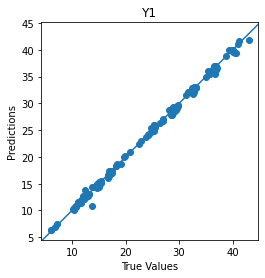

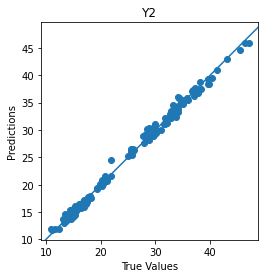

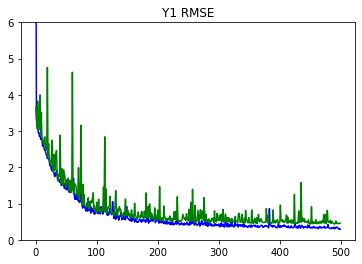

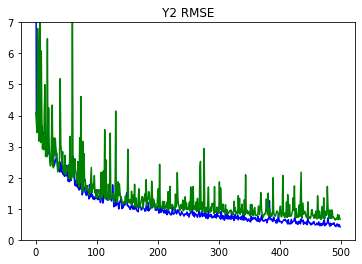

In [8]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)